# Improving Mock Data Errors with Empirical Results

The data in this notebook is generated in the same way as in `Bootstrap-Own-Data.ipynb`. However, instead of bootstrapping to get error estimates, each sample will be given it's own error estimate based on the mass-to-distance ratio, $\frac{m_1}{d_L}$. The exact formula comes from a logramthic least-squares fit from the LIGO O3a and b datasets, which can be found [here](https://github.com/ctmurphey/Combined-O3ab). These functions are already stored in `MCMC_functions.py`.

In [1]:
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import arviz as az
from astropy.cosmology import Planck18
from tqdm import tqdm
import seaborn as sns
from MCMC_functions import *
from astropy.cosmology import units as cu

sns.set_context('notebook')
sns.set_palette('colorblind')

import matplotlib
matplotlib.rcParams['font.family'] = 'serif' # so these plots can go into thesis


%matplotlib inline

21.753810721614013 2.3509874679996625 72.88534637226181
(10000,)


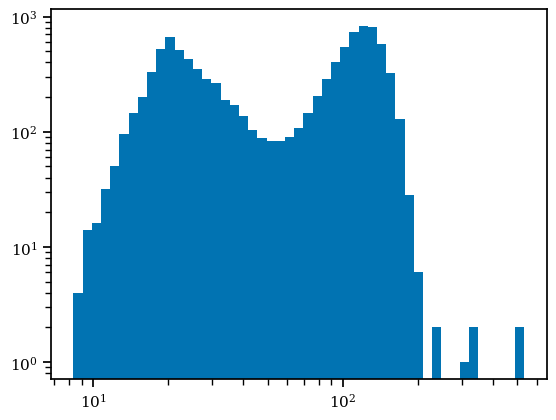

In [2]:
ms = generate_masses(f=0.5)
dLs = generate_dLs()
zs = dLs_to_zs(dLs)

m_det = ms*(1+zs)
print(np.mean(ms), np.mean(zs), np.mean(m_det))
print(m_det.shape)
plt.hist(m_det, bins=np.logspace(np.log10(min(m_det)), np.log10(max(m_det)), 50))
plt.xscale('log')
plt.yscale('log')

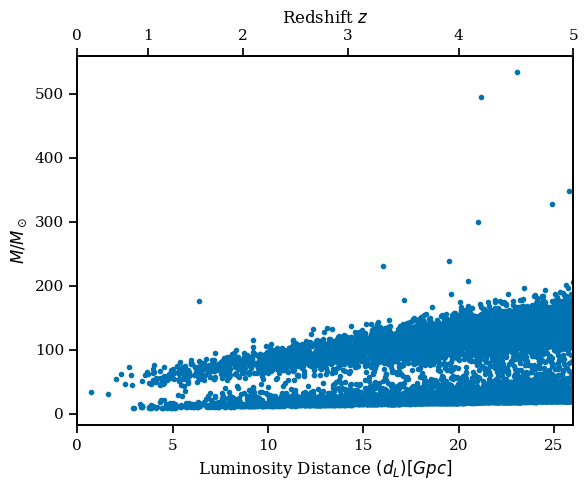

In [3]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.scatter(dLs/1000, m_det, marker='.')
ax1.set_xlabel(r"Luminosity Distance $(d_L) [Gpc]$")
ax1.set_ylabel(r"$M/M_\odot$")

tick_labels = np.linspace(0, 5, 6, dtype=int)
new_tick_locations = Planck18.luminosity_distance(tick_labels)
ax2.set_xlim(0, 5)
ax1.set_xlim(0, max(dLs/1000))
ax2.set_xticks(new_tick_locations.value)
ax2.set_xticklabels(tick_labels)
ax2.set_xlabel(r"Redshift $z$")
plt.show()

In [4]:
m_dls = m_det/dLs
sigma_dls = sigma_dL(m_dls)
sigma_ms  = sigma_m(m_dls)

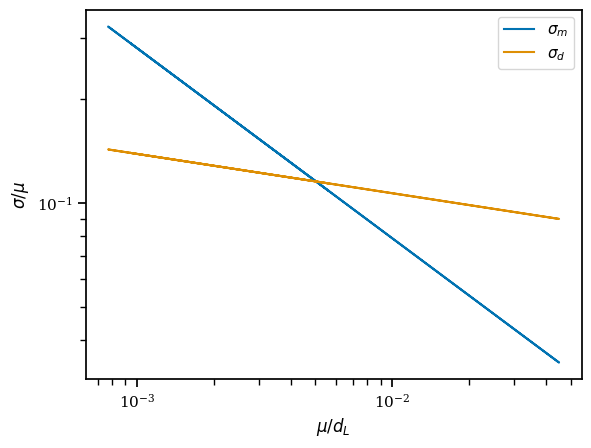

In [5]:
plt.loglog(m_dls, sigma_ms, label=r"$\sigma_m$")
plt.loglog(m_dls, sigma_dls, label=r"$\sigma_d$")
plt.xlabel(r"$\mu/d_L$")
plt.ylabel(r"$\sigma/\mu$")
plt.legend()

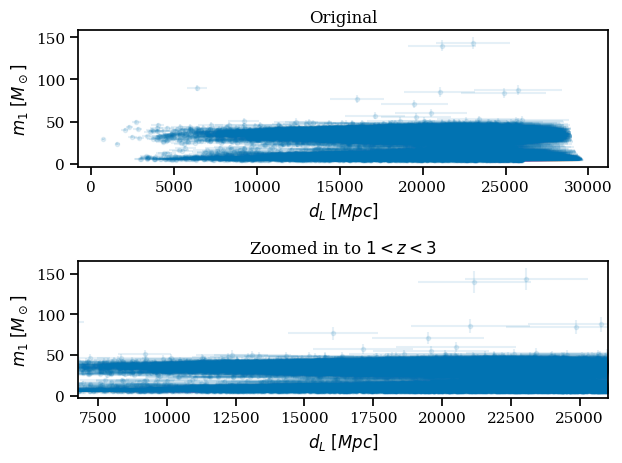

In [6]:
fig, axs = plt.subplots(2, 1)

axs[0].errorbar(dLs, ms, xerr=sigma_dls*dLs, yerr=sigma_ms*ms, fmt='.', alpha=0.1)
axs[0].set_xlabel(r"$d_L\ [Mpc]$")
axs[0].set_ylabel(r"$m_1\ [M_\odot]$")
axs[0].set_title("Original")

axs[1].errorbar(dLs, ms, xerr=sigma_dls*dLs, yerr=sigma_dls*ms, fmt='.', alpha=0.1)
axs[1].set_xlabel(r"$d_L\ [Mpc]$")
axs[1].set_ylabel(r"$m_1\ [M_\odot]$")
axs[1].set_xlim(Planck18.luminosity_distance(1).value, Planck18.luminosity_distance(3).value)
axs[1].set_title(r"Zoomed in to $1<z<3$")
fig.tight_layout()

100%|██████████| 8/8 [01:18<00:00,  9.80s/it]


Text(0, 0.5, '$m_\\mathrm{peak} / M_\\odot$')

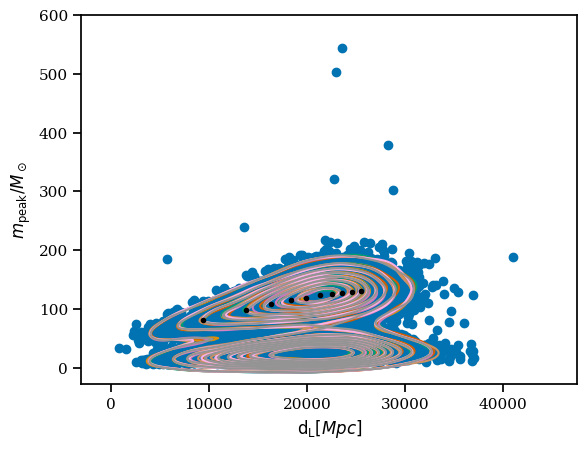

In [7]:
n_events = len(m_det)
n_dLs=10
n_mc = 8
m_min = min(m_det)
m_max = max(m_det)
dL_min = min(dLs)
dL_max = max(dLs)

m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
dL_cent = np.quantile(dLs, np.linspace(0.05, 0.95, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

for run in tqdm(range(n_mc)):

    m_det_mc = np.random.lognormal(mean=np.log(m_det), sigma=sigma_ms)
    # print(m_det_mc[0])
    d_Ls_mc = np.random.lognormal(mean=np.log(dLs), sigma=sigma_dls)


    
    arr = np.array([d_Ls_mc, m_det_mc])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        # redshift_min = cosmo.z_at_value(Planck18.luminosity_distance)
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:])
    
    kplot = sns.kdeplot(x=d_Ls_mc, y=m_det_mc)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(d_Ls_mc, m_det_mc)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
# plt.xlim(Planck18.luminosity_distance(0).value, Planck18.luminosity_distance(4).value)
# plt.ylim(30, 50)

<ErrorbarContainer object of 3 artists>

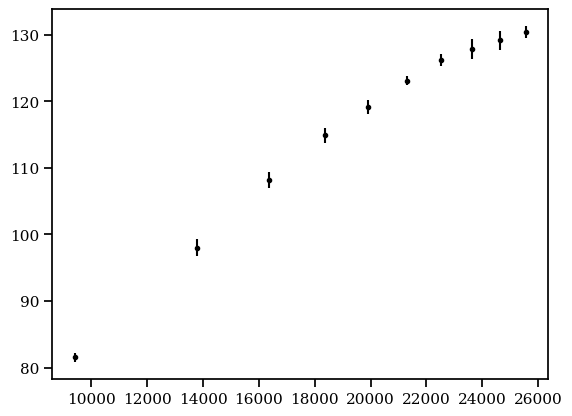

In [8]:
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 55 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.


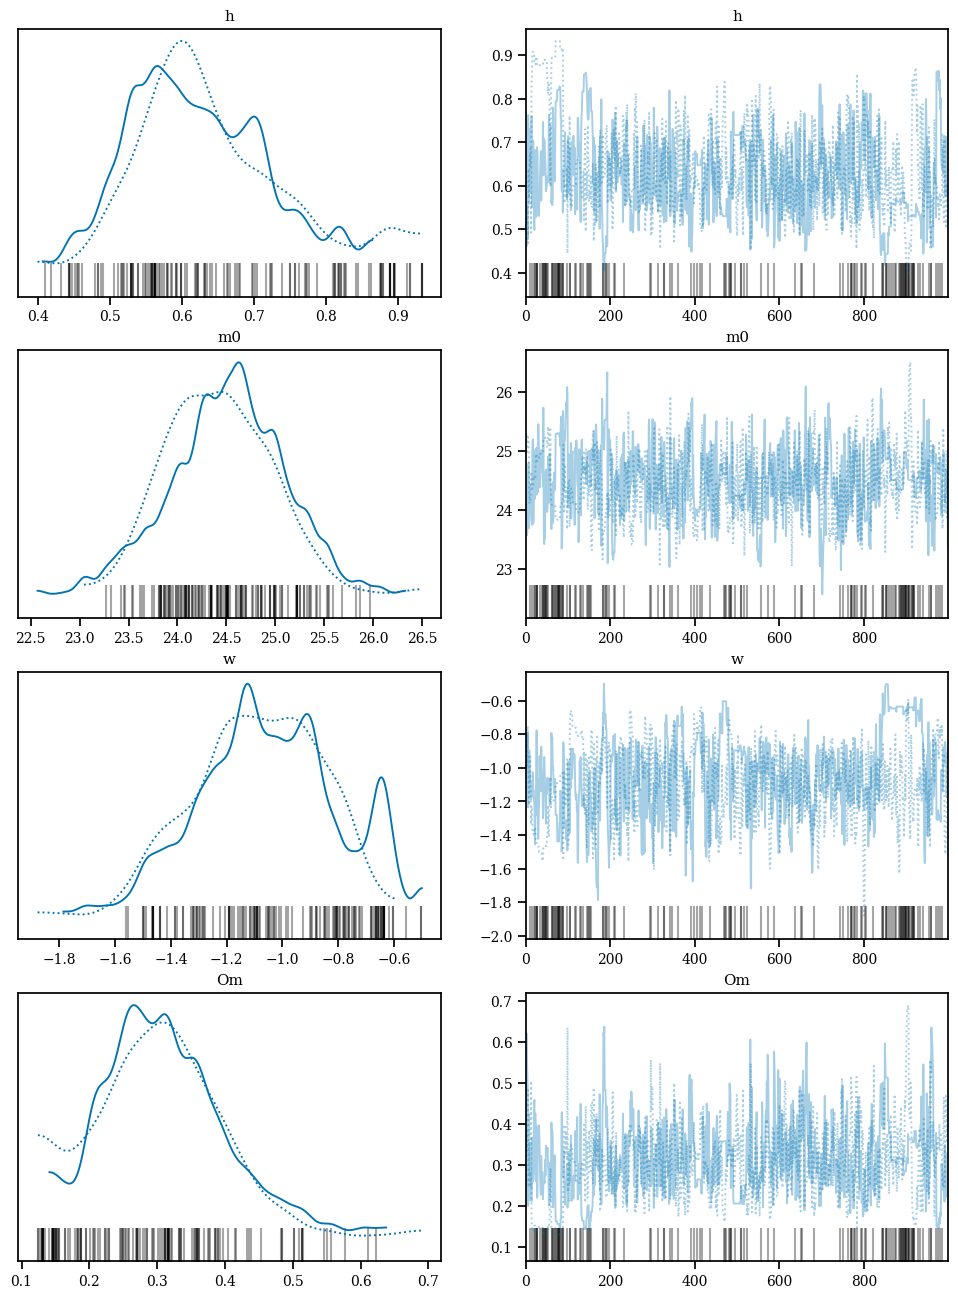

In [9]:
mu_m = np.mean(mpeak_samples, axis=0)
sigmam = np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_m, sigma_ms_obs=sigmam, dls=dL_cent, zmin=1, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'], figsize=(12, 16))
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

<ErrorbarContainer object of 3 artists>

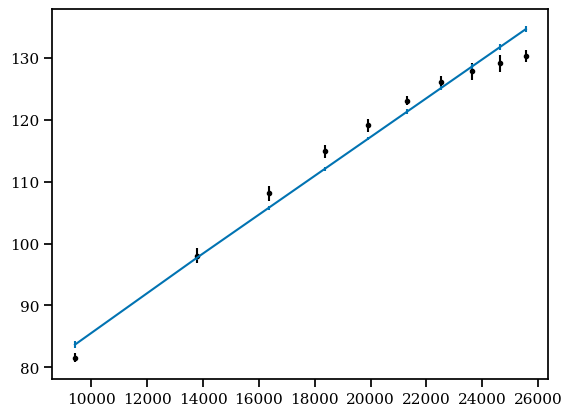

In [10]:
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.errorbar(dL_cent, trace.posterior['m_peak'].mean(dim=['chain', 'draw']), yerr=trace.posterior['m_peak'].std(dim=['chain', 'draw']))

array([[<AxesSubplot:ylabel='Om'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='h', ylabel='w'>, <AxesSubplot:xlabel='Om'>]],
      dtype=object)

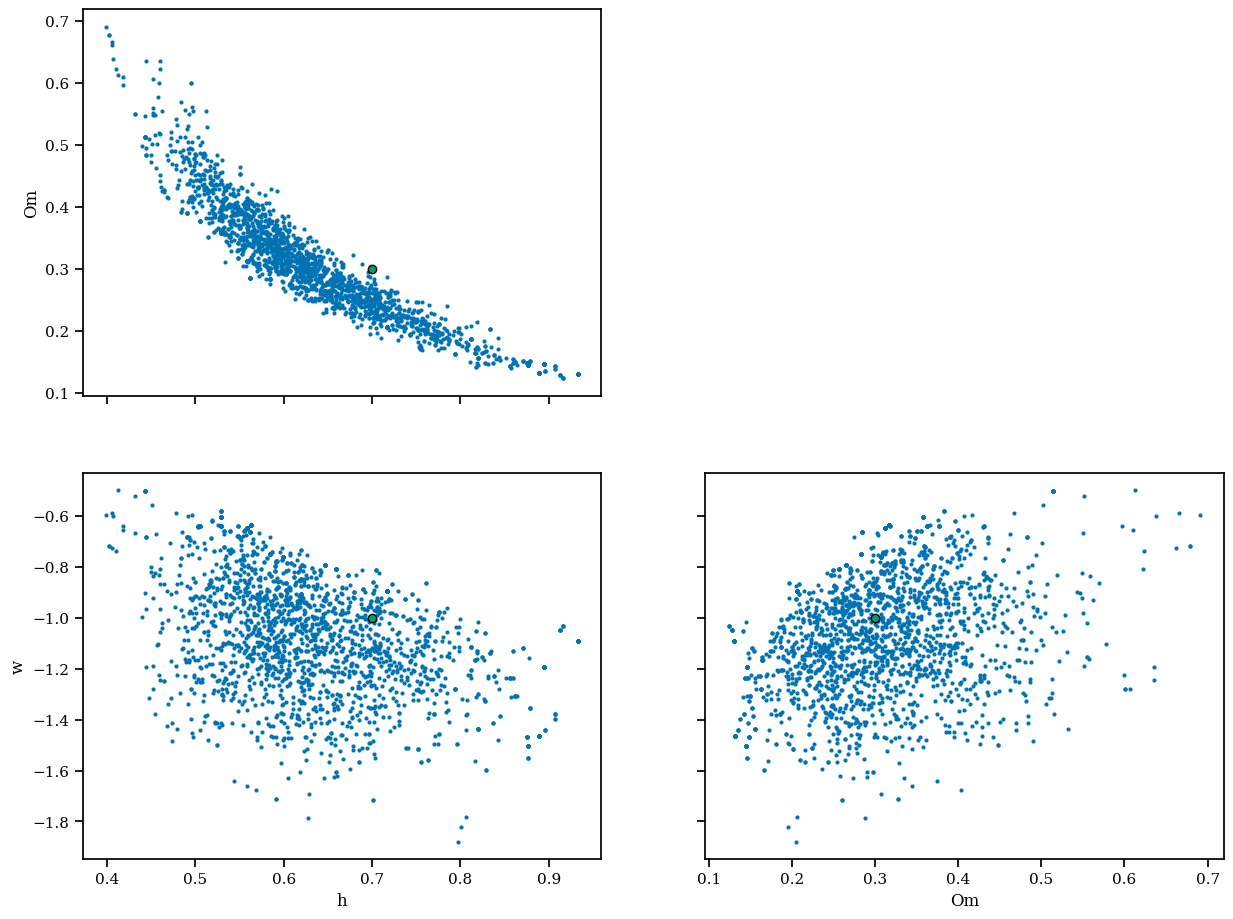

In [11]:
az.plot_pair(trace, var_names=['h', 'Om', 'w'], reference_values={'h': 0.7, 'Om':0.3, 'w':-1})

## Drop redshift down to $z=0$ using same method as in `Bootstrap-Own-Data.ipynb`


100%|██████████| 8/8 [01:14<00:00,  9.35s/it]


(-27.942800968354437, 250.0)

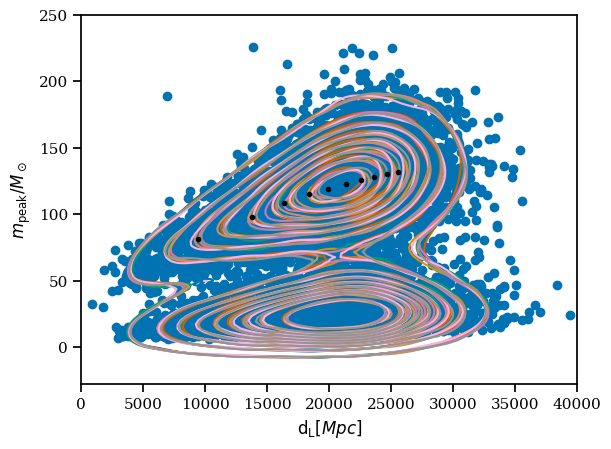

In [12]:
n_events = len(m_det)
n_dLs=10
n_mc = 8
m_min = min(m_det)
m_max = max(m_det)
dL_min = min(dLs)
dL_max = max(dLs)

m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
dL_cent = np.quantile(dLs, np.linspace(0.05, 0.95, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

for run in tqdm(range(n_mc)):

    m_det_mc = np.random.lognormal(mean=np.log(m_det), sigma=sigma_ms)
    # print(m_det_mc[0])
    d_Ls_mc = np.random.lognormal(mean=np.log(dLs), sigma=sigma_dls)


    
    arr = np.array([d_Ls_mc, m_det_mc])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        redshifted_min = 25*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent[i]*u.Mpc))
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:], mmin=redshifted_min)
    
    kplot = sns.kdeplot(x=d_Ls_mc, y=m_det_mc)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(d_Ls_mc, m_det_mc)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
plt.xlim(0,40000)
plt.ylim(top=250)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.
There were 466 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1775, but should be close to 0.8. Try to increase the number of tuning steps.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.


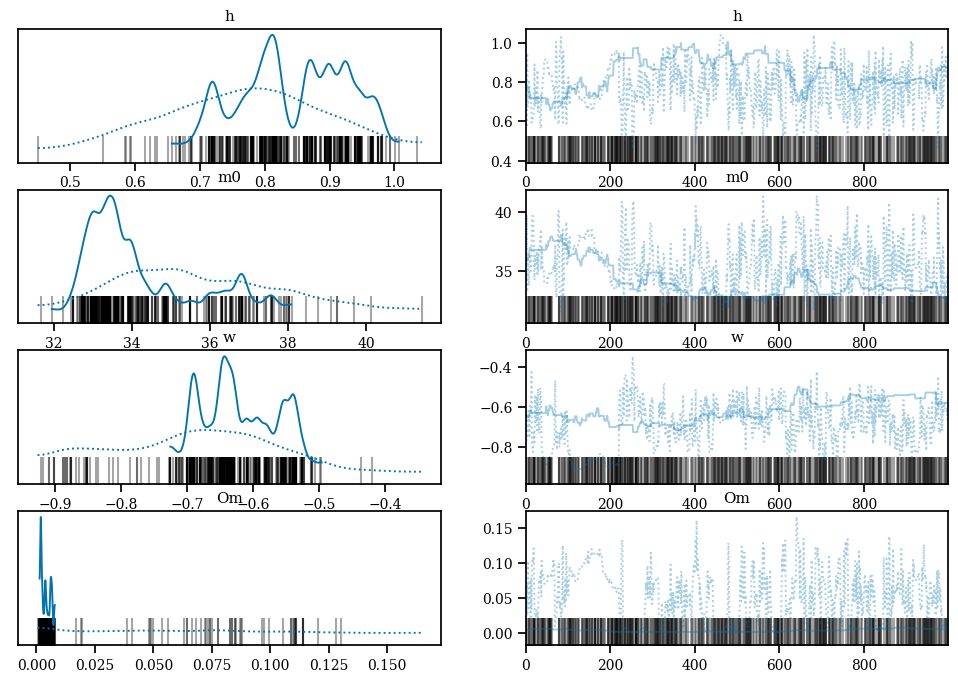

In [13]:
with make_model(ms_obs=mu_m, sigma_ms_obs=sigmam, dls=dL_cent, zmin=0, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

<ErrorbarContainer object of 3 artists>

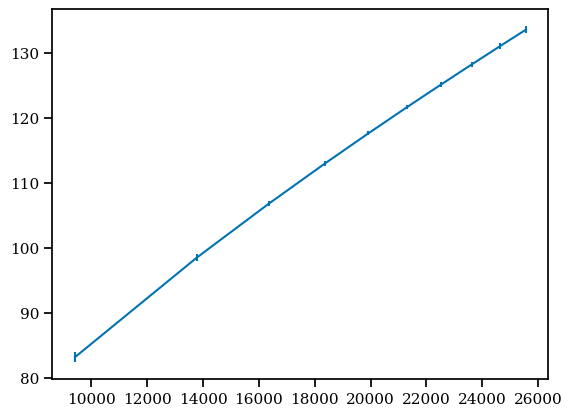

In [14]:
plt.errorbar(dL_cent, trace.posterior['m_peak'].mean(dim=['chain', 'draw']), yerr=trace.posterior['m_peak'].std(dim=['chain', 'draw']))

## Chopping off high $d_L$
It looks like the peak finder dips down a little towards the end for some (currently unknown) reason. The temporary solution to this is to simply stop before that. We'll also do some sigma clipping later to see if the issue is actually just that the errors are too large that far away since $d_L$ is in the denominator of the error functions.

100%|██████████| 8/8 [00:55<00:00,  7.00s/it]


(-27.39750958323292, 250.0)

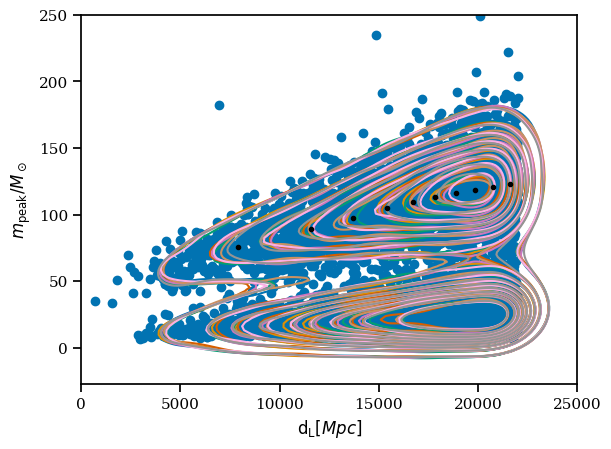

In [15]:
cutoff_d = 22000
m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
d_Ls_mc = np.random.lognormal(mean=np.log(dLs), sigma=sigma_dls)
d_low_dl = d_Ls_mc[d_Ls_mc < cutoff_d]
dL_cent = np.quantile(d_low_dl, np.linspace(0.05, 0.95, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

for run in tqdm(range(n_mc)):

    m_det_mc = np.random.lognormal(mean=np.log(m_det), sigma=sigma_ms)
    d_Ls_mc = np.random.lognormal(mean=np.log(dLs), sigma=sigma_dls)

    d_low_dl = d_Ls_mc[d_Ls_mc < cutoff_d]
    m_low_dl = m_det_mc[d_Ls_mc < cutoff_d]
    
    arr = np.array([d_low_dl, m_low_dl])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        redshifted_min = 25*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent[i]*u.Mpc))
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:], mmin=redshifted_min)
    
    kplot = sns.kdeplot(x=d_low_dl, y=m_low_dl)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(d_low_dl, m_low_dl)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
plt.xlim(0,25000)
plt.ylim(top=250)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 61 seconds.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6952, but should be close to 0.8. Try to increase the number of tuning steps.
There were 311 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4284, but should be close to 0.8. Try to increase the number of tuning steps.


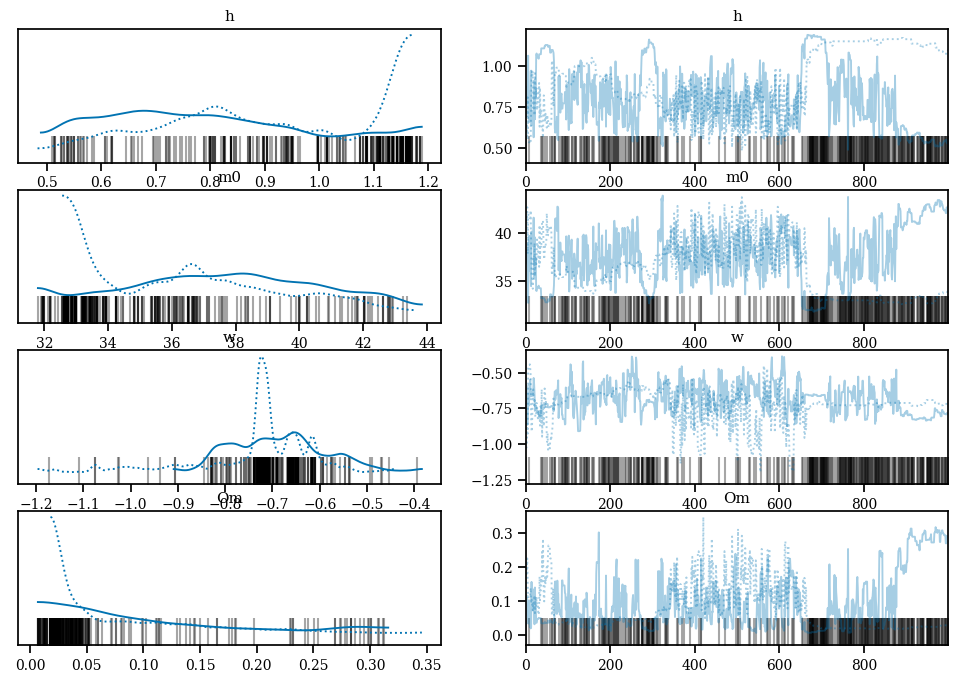

In [16]:
with make_model(ms_obs=mu_m, sigma_ms_obs=sigmam, dls=dL_cent, zmin=0, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

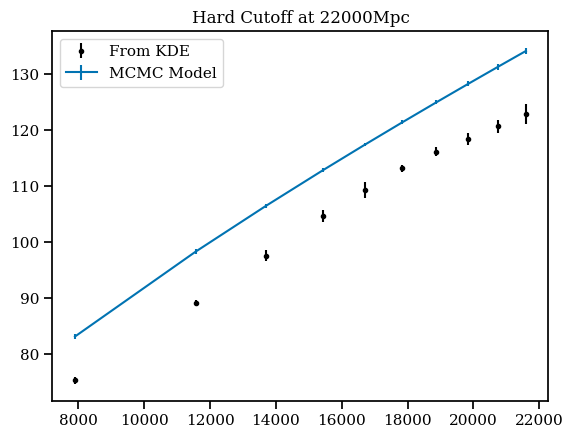

In [17]:
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k', label="From KDE")
plt.errorbar(dL_cent, trace.posterior['m_peak'].mean(dim=['chain', 'draw']), yerr=trace.posterior['m_peak'].std(dim=['chain', 'draw']), label="MCMC Model")
plt.title(f"Hard Cutoff at {cutoff_d}Mpc")
plt.legend()

# $\sigma$-clipping:
The section above where the errors were first introduced has the odd combination of assuming LIGO sees every event while also putting in a measurement error that roughly depends on how detectable the object is. In the next section, objects where $\frac{\sigma}{\mu}>\sigma_{cut}$ for _either_ $m_1$ or $d_L$ will be removed, as LIGO would likely ignore them anyways. Looking at the line plot of two error functions way above, this will likely remove quite a few of them

In [42]:
sigma_cut = 0.2 ## roughly correponds to SNR of 5
ms = generate_masses(f=0.5)
dLs = generate_dLs(R=Planck18.luminosity_distance(5))
zs = dLs_to_zs(dLs)
m_det = ms*(1+zs)
dL_cut = dLs[(sigma_dls < sigma_cut) & (sigma_ms < sigma_cut)]
ms_cut = m_det[(sigma_dls < sigma_cut) & (sigma_ms < sigma_cut)]
sigma_ms_cut = sigma_ms[(sigma_dls < sigma_cut) & (sigma_ms < sigma_cut)]
sigma_dL_cut = sigma_dls[(sigma_dls < sigma_cut) & (sigma_ms < sigma_cut)]
print(len(dLs), len(dL_cut))
print(len(ms_cut)) #just a sanity check

10000 5939
5939


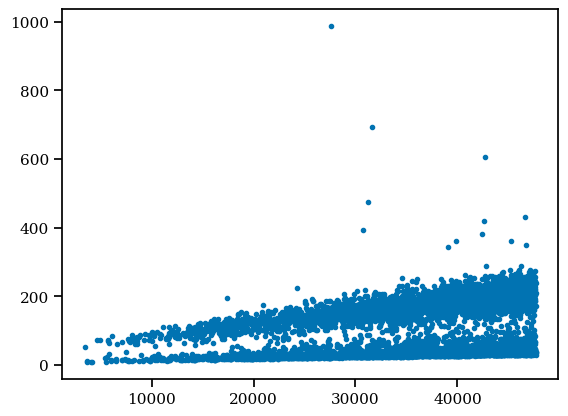

In [43]:
plt.scatter(dL_cut, ms_cut, marker='.')

100%|██████████| 8/8 [00:43<00:00,  5.49s/it]


(-47.48384569652457, 250.0)

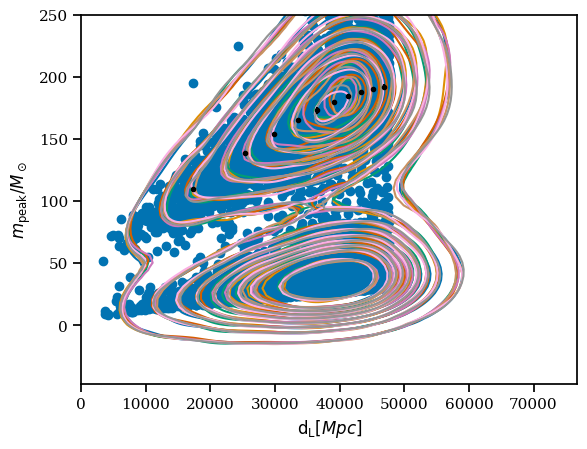

In [44]:
# To calibrate m_grid and dL_cent
m_det_mc = np.random.lognormal(mean=np.log(ms_cut), sigma=sigma_ms_cut)
d_Ls_mc = np.random.lognormal(mean=np.log(dL_cut), sigma=sigma_dL_cut)

n_events = len(m_det_mc)
n_dLs=10
n_mc = 8
m_min = min(m_det_mc)
m_max = max(m_det_mc)
dL_min = min(d_Ls_mc)
dL_max = max(d_Ls_mc)

m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
dL_cent = np.quantile(dLs, np.linspace(0.05, 0.95, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

for run in tqdm(range(n_mc)):

    m_det_mc = np.random.lognormal(mean=np.log(ms_cut), sigma=sigma_ms_cut)
    # print(m_det_mc[0])
    d_Ls_mc = np.random.lognormal(mean=np.log(dL_cut), sigma=sigma_dL_cut)


    
    arr = np.array([d_Ls_mc, m_det_mc])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        redshifted_min = 25*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent[i]*u.Mpc))
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:], mmin=redshifted_min)
    
    kplot = sns.kdeplot(x=d_Ls_mc, y=m_det_mc)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(dL_cut, ms_cut)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
plt.xlim(0)
plt.ylim(top=250)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 55 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8973, but should be close to 0.8. Try to increase the number of tuning steps.
There were 168 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6483, but should be close to 0.8. Try to increase the number of tuning steps.


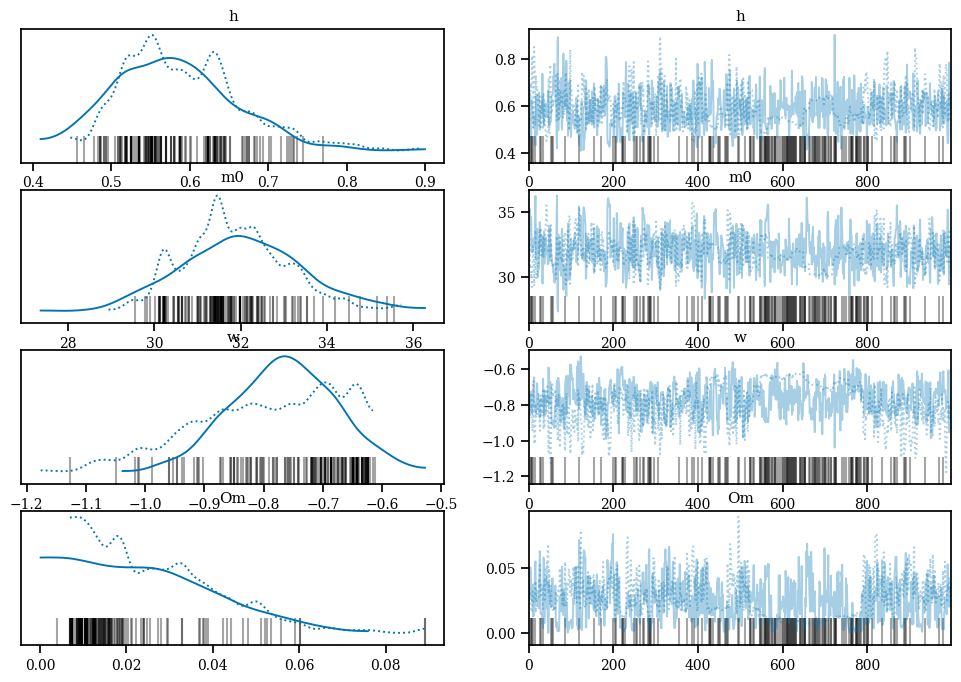

In [45]:
with make_model(ms_obs=mu_m, sigma_ms_obs=sigmam, dls=dL_cent, zmin=0, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

array([[<AxesSubplot:ylabel='Om'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='h', ylabel='w'>, <AxesSubplot:xlabel='Om'>]],
      dtype=object)

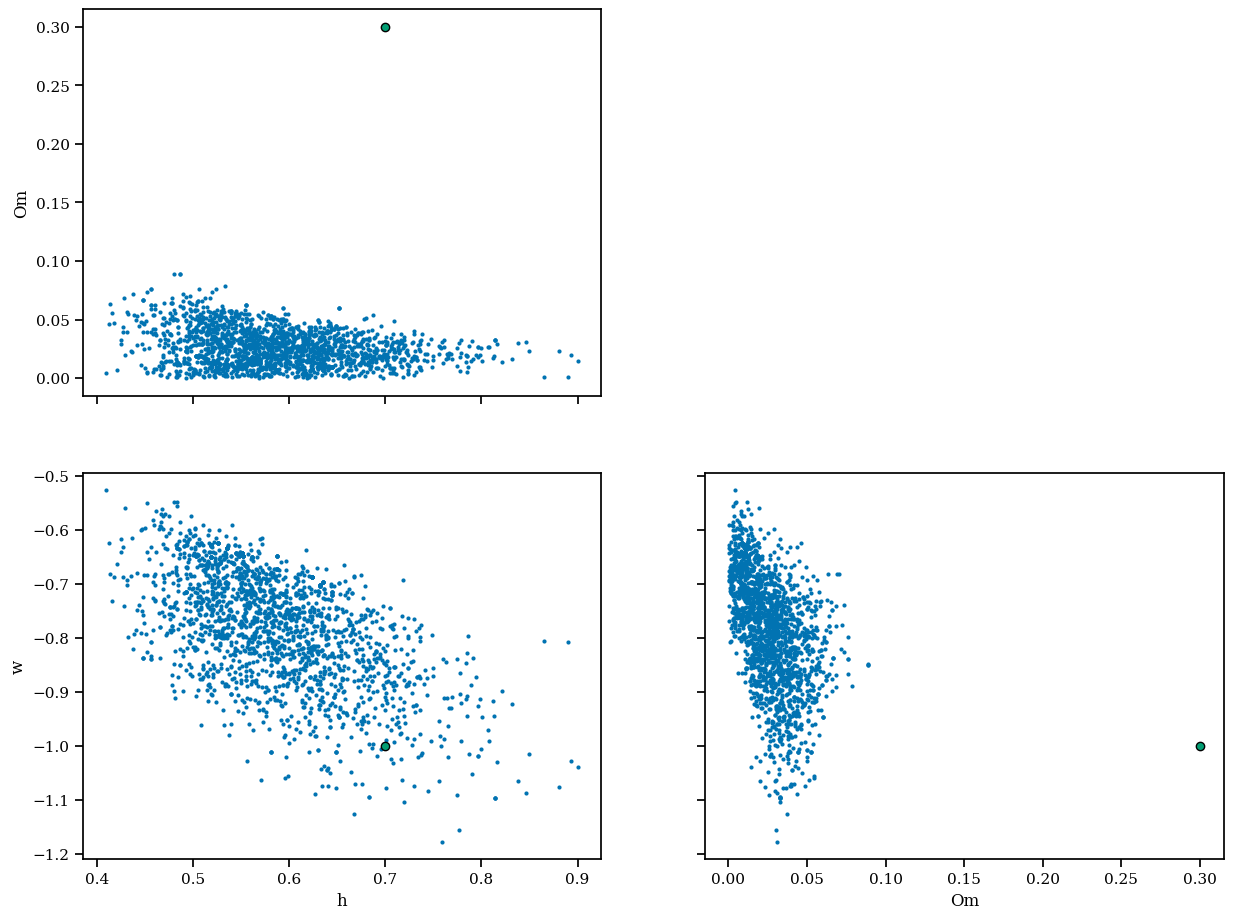

In [46]:
az.plot_pair(trace, var_names=['h', 'Om', 'w'], reference_values={'h': 0.7, 'Om':0.3, 'w':-1})

In [35]:
print(max(dL_cut), Planck18.luminosity_distance(3))

26015.262612836308 26016.015955798568 Mpc
